# Context

## Tools

*Modules*

In [1]:
import numpy as np
import numpy.random as rd
import math as m
import pandas as pd
import warnings
import json
from astropy.time import Time

import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import matplotlib.cm as cmx
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ti
from matplotlib import patheffects
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.legend_handler import HandlerTuple
from fontTools.ttLib import TTFont
from matplotlib.font_manager import fontManager, FontProperties
from adjustText import adjust_text
import seaborn as sns
import cmcrameri.cm as cmc

import geopandas as gpd
import cartopy
import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
import cartopy.feature as cf
import pygmt
from pygmt.datasets import load_earth_relief
import fiona
from shapely import geometry
from shapely.geometry import shape
import cartopy.io.shapereader as shapereader
from osgeo import gdal, osr
from cartopy.io.srtm import add_shading

In [2]:
plt.style.use('myfig.mplstyle')

*Functions*

In [3]:
def found_font_with_unicode_char(list_unichars):
    
    def char_in_font(unicode_char, font):
        if font.endswith('.ttc'):
            fontNo = 0
        else:
            fontNo = -1
        font = TTFont(font, fontNumber=fontNo)
        for cmap in font['cmap'].tables: 
            if cmap.isUnicode():
                for i in unicode_char:
                    if ord(i) not in cmap.cmap:
                        return False
        return True

    font_list = [(f.fname, f.name) for f in fontManager.ttflist]
    for font in font_list:
        if char_in_font(list_unichars, font[0]):
            return FontProperties(fname=font[0])
    
    return None


def draw_scalebar(ax, length, location=(.9, .9), linewidth=3, units='km', m_per_unit=1000):    
    """
    http://stackoverflow.com/a/35705477/1072212
    ax is the axes to draw the scalebar on.
    proj is the projection the axes are in
    location is center of the scalebar in axis coordinates ie. 0.5 is the middle of the plot
    length is the length of the scalebar in km.
    linewidth is the thickness of the scalebar.
    units is the name of the unit
    m_per_unit is the number of meters in a unit
    """
    
    def utm_from_lon(lon):
        """
        utm_from_lon - UTM zone for a longitude
        Not right for some polar regions (Norway, Svalbard, Antartica)
        :param float lon: longitude
        :return: UTM zone number
        :rtype: int
        """
        return int(np.floor((lon+180)/6)+1)
    
    proj = ax.projection
    # find lat/lon center to find best UTM zone
    x0, x1, y0, y1 = ax.get_extent(proj.as_geodetic())
    # Projection in metres
    utm = ccrs.UTM(utm_from_lon((x0+x1)/2))
    # Get the extent of the plotted area in coordinates in metres
    x0, x1, y0, y1 = ax.get_extent(utm)
    # Turn the specified scalebar location into coordinates in metres
    sbcx, sbcy = x0 + (x1 - x0) * location[0], y0 + (y1 - y0) * location[1]
    # Generate the x coordinate for the ends of the scalebar
    bar_xs = [sbcx - length * m_per_unit/2, sbcx + length * m_per_unit/2]
    # buffer for scalebar
    buffer = [patheffects.withStroke(linewidth=5, foreground="w")]
    # Plot the scalebar with buffer
    ax.plot(bar_xs, [sbcy, sbcy], transform=utm, color='k',
            linewidth=linewidth, path_effects=buffer)
    # Plot the scalebar label
    ax.text(sbcx, sbcy+(y1 - y0)*0.01, '{:} {:}'.format(length, units), transform=utm,
            ha='center', va='bottom', path_effects=buffer, zorder=2)
    return


def draw_north_arrow(ax, location=(.1, .9)):    
    """
    http://stackoverflow.com/a/35705477/1072212
    ax is the axes to draw the scalebar on.
    proj is the projection the axes are in
    location is center of the scalebar in axis coordinates ie. 0.5 is the middle of the plot
    length is the length of the scalebar in km.
    linewidth is the thickness of the scalebar.
    units is the name of the unit
    m_per_unit is the number of meters in a unit
    """
    
    def utm_from_lon(lon):
        """
        utm_from_lon - UTM zone for a longitude
        Not right for some polar regions (Norway, Svalbard, Antartica)
        :param float lon: longitude
        :return: UTM zone number
        :rtype: int
        """
        return int(np.floor((lon+180)/6)+1)
    
    proj = ax.projection
    # find lat/lon center to find best UTM zone
    x0, x1, y0, y1 = ax.get_extent(proj.as_geodetic())
    utm = ccrs.UTM(utm_from_lon((x0+x1)/2))
    x0, x1, y0, y1 = ax.get_extent(utm)
    # Turn the arow location into coordinates in metres
    sbcx = x0 + (x1 - x0) * location[0]
    sbcy = y0 + (y1 - y0) * location[1]
    # buffer and plot
    buffer = [patheffects.withStroke(linewidth=3, foreground="w")]
    ax.text(sbcx, sbcy, u'\u25B2\nN', fontproperties=found_font_with_unicode_char([u"\u25B2"]),
            transform=utm, ha='center', va='bottom', path_effects=buffer)
    return

*Paths*

In [4]:
# paths
wkdir = "/Users/emile/Documents/Etude/2024_2025_M2/tutored_project"
datadir = "{:}/data".format(wkdir)
plotdir = "{:}/figures".format(wkdir)

*Data*

In [5]:
# regions
region = [33, 37, 29, 34]

In [6]:
# topography
relief = load_earth_relief(resolution="01m", registration="gridline", region=region)

In [7]:
# hydrological shapefiles
lakes = gpd.read_file("{:}/Dead_Sea_shapefile/lakes.shp".format(datadir))
rivers = gpd.read_file("{:}/Dead_Sea_shapefile/rivers.shp".format(datadir))

In [8]:
# Dea Sea level
dead_sea_level = pd.read_csv("{:}/Dead_Sea_level/Dead_Sea_level.csv".format(datadir))

In [9]:
# InSAR time periods
insar_asc_tinf = '2015-03-04'
insar_asc_tsup = '2021-04-25'

insar_desc_tinf = '2014-10-31'
insar_desc_tsup = '2021-04-27'

insar_asc_tinf_yr = Time(insar_asc_tinf).decimalyear
insar_asc_tsup_yr = Time(insar_asc_tsup).decimalyear

insar_desc_tinf_yr = Time(insar_desc_tinf).decimalyear
insar_desc_tsup_yr = Time(insar_desc_tsup).decimalyear

In [10]:
insar_asc_track = geometry.Polygon([[34.574, 28.6281],[37.1242, 29.1537],[35.9563, 35.0585],[33.1908, 34.7032],[34.574, 28.6281]])
insar_desc_track = geometry.Polygon([[37.8638, 33.7557], [35.1275, 34.0437], [33.9987, 28.3143], [36.569, 28.0204], [37.8638, 33.7557]])

In [11]:
# GNSS time periods
gnss_tinf = '2005-01-01'
gnss_tsup = '2025-01-01'

gnss_tinf_yr = Time(gnss_tinf).decimalyear
gnss_tsup_yr = Time(gnss_tsup).decimalyear

In [12]:
# landsat historical data
landsat_names = ['LM01_187038_19730119', 'LT05_174038_19840618', 'LT05_174038_19930323', 'LT05_174038_20031013', 'LE07_174038_20130407', 'LE07_174038_20230806']
landsat_dates = ['1973-01-19', '1984-06-18', '1993-03-23', '2003-10-13', '2013-04-07', '2023-06-06']

landsat_images = {}

for fname in landsat_names:

    ds = gdal.Open("{:}/LANDSAT/{:}.tif".format(datadir, fname))
        
    geotransform = ds.GetGeoTransform()
    cols = ds.RasterXSize
    rows = ds.RasterYSize
    extent = (geotransform[0], geotransform[0] + cols * geotransform[1],
                geotransform[3] + rows * geotransform[5], geotransform[3])

    img = ds.ReadAsArray().astype(float) / 255
    img = np.transpose(img, (1, 2, 0))
    # img[np.repeat((img == [0, 0, 0]).all(axis=2)[:, :, np.newaxis], 3, axis=2)] = np.nan
    
    if 'LE07' in fname or 'LM01' in fname:
        img = img[:, :, [2, 1, 0]]
    else:
        img = img[:, :, [0, 2, 1]]
        
    brightness = 1.3

    img = np.clip(img*brightness, 0, 1)

    gamma = .9
    img = np.power(img, 1/gamma)
    
    landsat_images[fname] = {'image': img, 'extent': extent}

    del ds

/Users/emile/anaconda3/envs/pygdal/lib/python3.11/site-packages/osgeo/gdal.py:287: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


## Figures

/Users/emile/anaconda3/envs/pygdal/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:790: UserWarning: Approximating coordinate system <Geographic 2D CRS: GEOGCRS["unknown",DATUM["Unknown based on WGS 84 e ...>
Name: unknown
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- undefined
Datum: Unknown based on WGS 84 ellipsoid
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich
 with the PlateCarree projection.
  warnings.warn(f'Approximating coordinate system {crs!r} with '
/Users/emile/anaconda3/envs/pygdal/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:790: UserWarning: Approximating coordinate system <Geographic 2D CRS: GEOGCRS["unknown",DATUM["Unknown based on WGS 84 e ...>
Name: unknown
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- undefined
Datum: Unknown based on WGS 84 ellipsoid
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich
 with the PlateCarree projection.
  warni

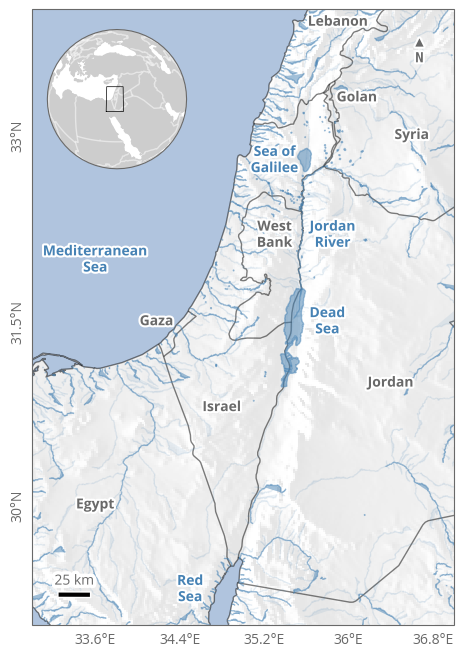

In [13]:
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': ccrs.Mercator()}, dpi=100)

ax.set_extent(region)
gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree())
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines = False
gl.xlocator = ti.MaxNLocator(5)
gl.ylocator = ti.MaxNLocator(4)
gl.ylabel_style = {'rotation': 90}

# topography
land_grad = pygmt.grdgradient(grid=relief, azimuth=255, normalize='e0.4')
ax.pcolormesh(relief.lon, relief.lat, land_grad, cmap=cmc.grayC, transform=ccrs.PlateCarree(), alpha=.1)

ax.add_feature(cf.BORDERS, linestyle='-', alpha=0.5, lw=1, edgecolor='k')
ax.add_feature(cf.OCEAN, facecolor='lightsteelblue', alpha=1, zorder=1)
ax.add_feature(cf.COASTLINE, linestyle='-', alpha=0.5, lw=1, edgecolor='k')

ax.add_geometries(lakes.geometry, crs=ccrs.PlateCarree(), linestyle='-', alpha=0.5, lw=1, color='steelblue')
ax.add_geometries(rivers[rivers.ORD_CLAS == 1].geometry, crs=ccrs.PlateCarree(), linestyle='-', alpha=.5, lw=1, color='steelblue')
ax.add_geometries(rivers[rivers.ORD_CLAS == 2].geometry, crs=ccrs.PlateCarree(), linestyle='-', alpha=.1, lw=1, color='steelblue')

draw_scalebar(ax, length=25, location=(.1, .05))
draw_north_arrow(ax, location=(.875, .91))

ax.text(36.4, 31, 'Jordan', transform=ccrs.PlateCarree(), va='center', ha='center', fontweight='bold', path_effects=[patheffects.withStroke(linewidth=3, foreground="w")])
ax.text(33.6, 30, 'Egypt', transform=ccrs.PlateCarree(), va='center', ha='center', fontweight='bold', path_effects=[patheffects.withStroke(linewidth=3, foreground="w")])
ax.text(34.8, 30.8, 'Israel', transform=ccrs.PlateCarree(), va='center', ha='center', fontweight='bold', path_effects=[patheffects.withStroke(linewidth=3, foreground="w")])
ax.text(35.9, 33.9, 'Lebanon', transform=ccrs.PlateCarree(), va='center', ha='center', fontweight='bold', path_effects=[patheffects.withStroke(linewidth=3, foreground="w")])
ax.text(36.6, 33, 'Syria', transform=ccrs.PlateCarree(), va='center', ha='center', fontweight='bold', path_effects=[patheffects.withStroke(linewidth=3, foreground="w")])
ax.text(34.18, 31.5, 'Gaza', transform=ccrs.PlateCarree(), va='center', ha='center', fontweight='bold', path_effects=[patheffects.withStroke(linewidth=3, foreground="w")])
ax.text(35.3, 32.2, 'West\nBank', transform=ccrs.PlateCarree(), va='center', ha='center', fontweight='bold', path_effects=[patheffects.withStroke(linewidth=3, foreground="w")])
ax.text(36.08, 33.3, 'Golan', transform=ccrs.PlateCarree(), va='center', ha='center', fontweight='bold', path_effects=[patheffects.withStroke(linewidth=3, foreground="w")])

ax.text(36.08, 33.3, 'Golan', transform=ccrs.PlateCarree(), va='center', ha='center', fontweight='bold', path_effects=[patheffects.withStroke(linewidth=3, foreground="w")])
ax.text(33.6, 32, 'Mediterranean\nSea', transform=ccrs.PlateCarree(), va='center', ha='center', fontweight='bold', color='steelblue', path_effects=[patheffects.withStroke(linewidth=3, foreground="w")])
ax.text(34.5, 29.3, 'Red\nSea', transform=ccrs.PlateCarree(), va='center', ha='center', fontweight='bold', color='steelblue', path_effects=[patheffects.withStroke(linewidth=3, foreground="w")])
ax.text(35.8, 31.5, 'Dead\nSea', transform=ccrs.PlateCarree(), va='center', ha='center', fontweight='bold', color='steelblue', path_effects=[patheffects.withStroke(linewidth=3, foreground="w")])
ax.text(35.3, 32.8, 'Sea of\nGalilee', transform=ccrs.PlateCarree(), va='center', ha='center', fontweight='bold', color='steelblue', path_effects=[patheffects.withStroke(linewidth=3, foreground="w")])
ax.text(35.85, 32.2, 'Jordan\nRiver', transform=ccrs.PlateCarree(), va='center', ha='center', fontweight='bold', color='steelblue', path_effects=[patheffects.withStroke(linewidth=3, foreground="w")])

# ax.add_geometries(insar_asc_track, facecolor='None', edgecolor='k', crs=ccrs.PlateCarree())
# ax.add_geometries(insar_desc_track, facecolor='None', edgecolor='k', crs=ccrs.PlateCarree())

ax2 = inset_axes(ax, width="33%", height="33%", loc="upper left",
                 bbox_to_anchor=(.02, .03, 1, 1), bbox_transform=ax.transAxes,
                 axes_class=cartopy.mpl.geoaxes.GeoAxes,
                 axes_kwargs={'projection':ccrs.NearsidePerspective(central_longitude=35.5, central_latitude=31.5, satellite_height=8E5)})

ax2.plot([region[0], region[0], region[1], region[1], region[0]],
         [region[2], region[3], region[3], region[2], region[2]],
         transform=ccrs.PlateCarree(), c='k', lw=.5)

# ax2.add_geometries(insar_asc_track, facecolor='None', edgecolor='k', crs=ccrs.PlateCarree())
# ax2.add_geometries(insar_desc_track, facecolor='None', edgecolor='k', crs=ccrs.PlateCarree())

ax2.add_feature(cf.OCEAN, zorder=0, facecolor='white')
ax2.add_feature(cf.LAND, zorder=0, edgecolor='#cdcdcd', facecolor='#cdcdcd')
ax2.add_feature(cf.BORDERS, linestyle='-', alpha=0.5, lw=1, edgecolor='white')
ax2.set_global()

fig.savefig("{:}/context_map.png".format(plotdir), dpi=fig.dpi, bbox_inches='tight')
plt.show(fig)

/Users/emile/anaconda3/envs/pygdal/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:790: UserWarning: Approximating coordinate system <Geographic 2D CRS: GEOGCRS["unknown",DATUM["Unknown based on WGS 84 e ...>
Name: unknown
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- undefined
Datum: Unknown based on WGS 84 ellipsoid
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich
 with the PlateCarree projection.
  warnings.warn(f'Approximating coordinate system {crs!r} with '
/Users/emile/anaconda3/envs/pygdal/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:790: UserWarning: Approximating coordinate system <Geographic 2D CRS: GEOGCRS["unknown",DATUM["Unknown based on WGS 84 e ...>
Name: unknown
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- undefined
Datum: Unknown based on WGS 84 ellipsoid
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich
 with the PlateCarree projection.
  warni

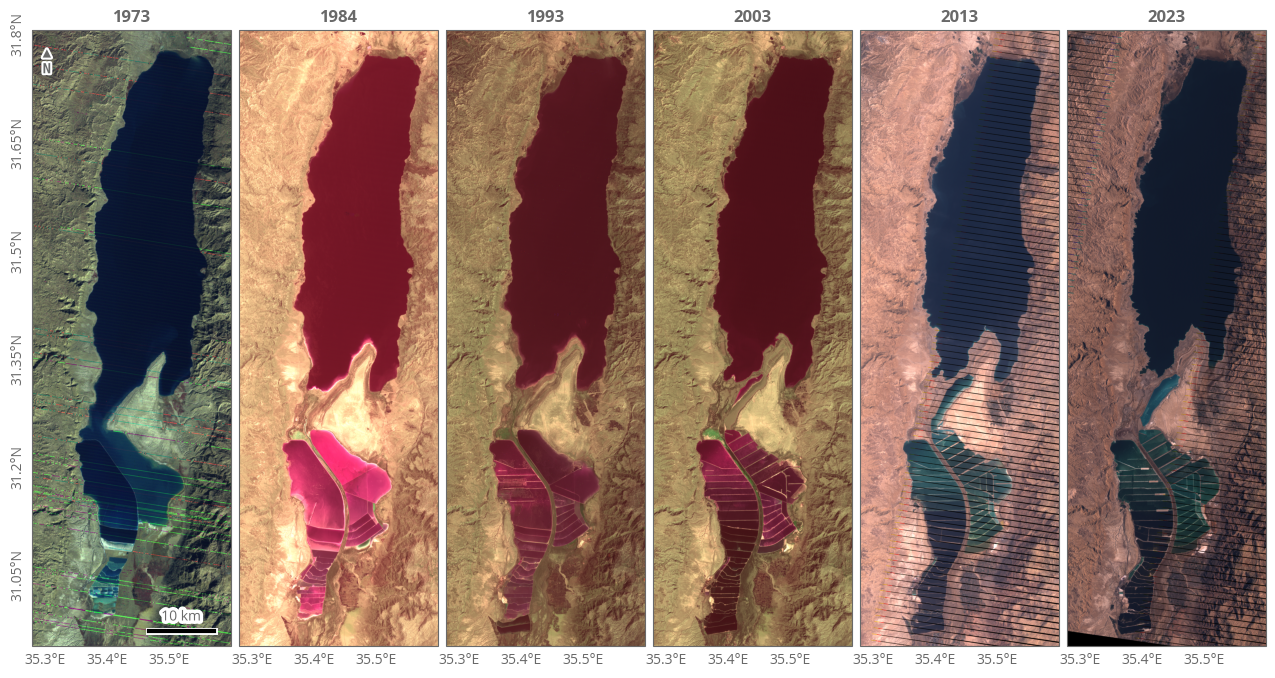

In [14]:
projection = ccrs.UTM(36)

fig, ax = plt.subplots(ncols=6, nrows=1, figsize=(16, 8), subplot_kw={'projection': projection})

for k in range(6):
    
    ax[k].set_title(Time(landsat_dates[k]).strftime('%Y'))
    ax[k].set_extent([35.3, 35.6, 30.95, 31.8])
    
    if k == 0:
    
        gl = ax[k].gridlines(draw_labels=True, crs=ccrs.PlateCarree())
        gl.top_labels = False
        gl.bottom_labels = True
        gl.right_labels = False
        gl.xlines = False
        gl.ylines = False
        gl.xlocator = ti.MaxNLocator(4)
        gl.ylocator = ti.MaxNLocator(7)
        gl.ylabel_style = {'rotation': 90}

    else:
    
        gl = ax[k].gridlines(draw_labels=True, crs=ccrs.PlateCarree())
        gl.top_labels = False
        gl.bottom_labels = True
        gl.right_labels = False
        gl.left_labels = False
        gl.xlines = False
        gl.ylines = False
        gl.xlocator = ti.MaxNLocator(4)
        gl.ylabel_style = {'rotation': 90}
    
    ax[k].imshow(landsat_images[landsat_names[k]]['image'], extent=landsat_images[landsat_names[k]]['extent'], origin='upper')

draw_scalebar(ax[0], length=10, location=(.75, .025))
draw_north_arrow(ax[0], location=(.075, .925))

plt.subplots_adjust(wspace=.01)
fig.savefig("{:}/context_dead_sea_evolution.png".format(plotdir), dpi=300, bbox_inches='tight')
plt.show()

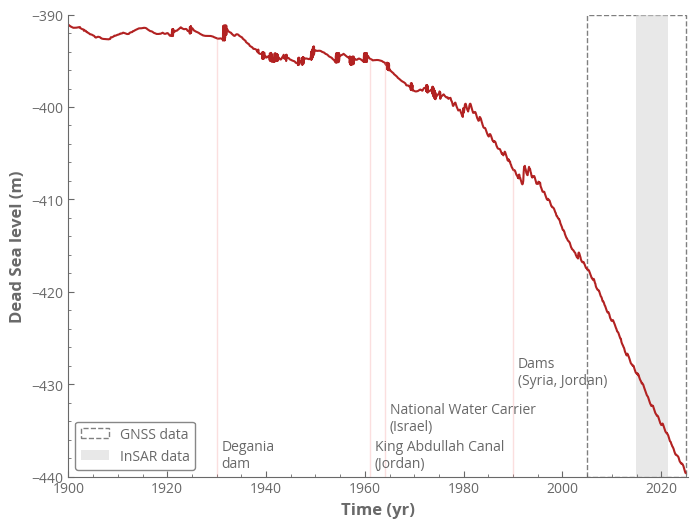

In [15]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(dead_sea_level.date_yr, dead_sea_level.sea_level, c='firebrick')

ax.set_xlabel('Time (yr)')
ax.set_ylabel('Dead Sea level (m)')

ax.axvspan(gnss_tinf_yr, gnss_tsup_yr, edgecolor='k', facecolor='None', alpha=.5, linestyle='--', label='GNSS data')

ax.axvspan(min(insar_asc_tinf_yr, insar_desc_tinf_yr), max(insar_asc_tsup_yr, insar_desc_tsup_yr),
           edgecolor='None', facecolor='lightgrey', alpha=.5, label='InSAR data')

t = 1930
ax.plot(2*[t], [-440, dead_sea_level.sea_level[np.argmin(np.abs(dead_sea_level.date_yr - t))]], c='lightcoral', lw=1, alpha=.25)
ax.text(t+1, -439, 'Degania\ndam', ha='left')

t = 1961
ax.plot(2*[t], [-440, dead_sea_level.sea_level[np.argmin(np.abs(dead_sea_level.date_yr - t))]], c='lightcoral', lw=1, alpha=.25)
ax.text(t+1, -439, 'King Abdullah Canal\n(Jordan)')

t = 1964
ax.plot(2*[t], [-440, dead_sea_level.sea_level[np.argmin(np.abs(dead_sea_level.date_yr - t))]], c='lightcoral', lw=1, alpha=.25)
ax.text(t+1, -435, 'National Water Carrier\n(Israel)')

t = 1990
ax.plot(2*[t], [-440, dead_sea_level.sea_level[np.argmin(np.abs(dead_sea_level.date_yr - t))]], c='lightcoral', lw=1, alpha=.25)
ax.text(t+1, -430, 'Dams\n(Syria, Jordan)')

ax.set_xlim(1900, 2025.5)
ax.set_ylim(-440, -390)

ax.legend(loc='lower left')

fig.savefig("{:}/context_dead_sea_level.png".format(plotdir), dpi=fig.dpi, bbox_inches='tight')
plt.show()

/Users/emile/anaconda3/envs/pygdal/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:790: UserWarning: Approximating coordinate system <Geographic 2D CRS: GEOGCRS["unknown",DATUM["Unknown based on WGS 84 e ...>
Name: unknown
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- undefined
Datum: Unknown based on WGS 84 ellipsoid
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich
 with the PlateCarree projection.
  warnings.warn(f'Approximating coordinate system {crs!r} with '
/Users/emile/anaconda3/envs/pygdal/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:790: UserWarning: Approximating coordinate system <Geographic 2D CRS: GEOGCRS["unknown",DATUM["Unknown based on WGS 84 e ...>
Name: unknown
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- undefined
Datum: Unknown based on WGS 84 ellipsoid
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich
 with the PlateCarree projection.
  warni

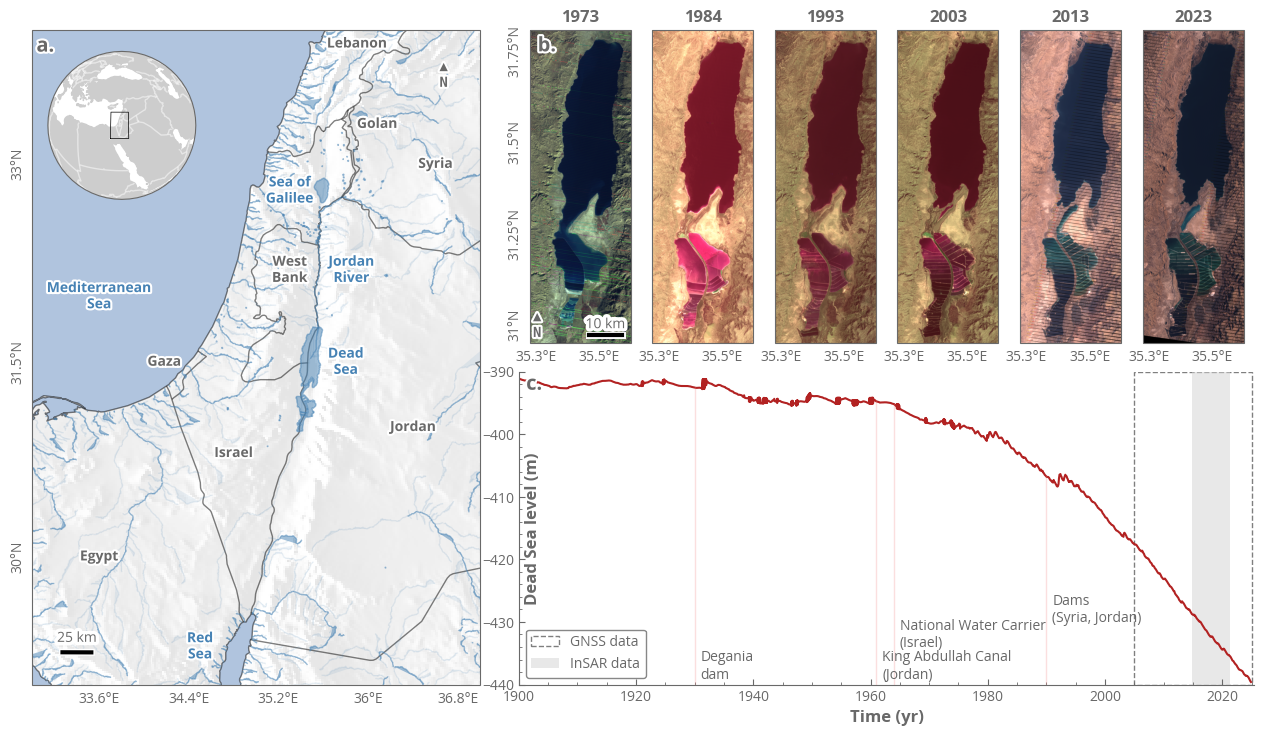

In [16]:
fig = plt.figure(figsize=(16, 8.5))
gs = gridspec.GridSpec(ncols=10, nrows=4, figure=fig)

################# Map #################

ax1 = fig.add_subplot(gs[:, :4], projection=ccrs.Mercator())

ax1.set_extent(region)
gl = ax1.gridlines(draw_labels=True, crs=ccrs.PlateCarree())
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines = False
gl.xlocator = ti.MaxNLocator(5)
gl.ylocator = ti.MaxNLocator(4)
gl.ylabel_style = {'rotation': 90}

# topography
land_grad = pygmt.grdgradient(grid=relief, azimuth=255, normalize='e0.4')
ax1.pcolormesh(relief.lon, relief.lat, land_grad, cmap=cmc.grayC, transform=ccrs.PlateCarree(), alpha=.1)

ax1.add_feature(cf.BORDERS, linestyle='-', alpha=0.5, lw=1, edgecolor='k')
ax1.add_feature(cf.OCEAN, facecolor='lightsteelblue', alpha=1, zorder=1)
ax1.add_feature(cf.COASTLINE, linestyle='-', alpha=0.5, lw=1, edgecolor='k')

ax1.add_geometries(lakes.geometry, crs=ccrs.PlateCarree(), linestyle='-', alpha=0.5, lw=1, color='steelblue')
ax1.add_geometries(rivers[rivers.ORD_CLAS == 1].geometry, crs=ccrs.PlateCarree(), linestyle='-', alpha=.5, lw=1, color='steelblue')
ax1.add_geometries(rivers[rivers.ORD_CLAS == 2].geometry, crs=ccrs.PlateCarree(), linestyle='-', alpha=.1, lw=1, color='steelblue')

draw_scalebar(ax1, length=25, location=(.1, .05))
draw_north_arrow(ax1, location=(.875, .91))

ax1.text(36.4, 31, 'Jordan', transform=ccrs.PlateCarree(), va='center', ha='center', fontweight='bold', path_effects=[patheffects.withStroke(linewidth=3, foreground="w")])
ax1.text(33.6, 30, 'Egypt', transform=ccrs.PlateCarree(), va='center', ha='center', fontweight='bold', path_effects=[patheffects.withStroke(linewidth=3, foreground="w")])
ax1.text(34.8, 30.8, 'Israel', transform=ccrs.PlateCarree(), va='center', ha='center', fontweight='bold', path_effects=[patheffects.withStroke(linewidth=3, foreground="w")])
ax1.text(35.9, 33.9, 'Lebanon', transform=ccrs.PlateCarree(), va='center', ha='center', fontweight='bold', path_effects=[patheffects.withStroke(linewidth=3, foreground="w")])
ax1.text(36.6, 33, 'Syria', transform=ccrs.PlateCarree(), va='center', ha='center', fontweight='bold', path_effects=[patheffects.withStroke(linewidth=3, foreground="w")])
ax1.text(34.18, 31.5, 'Gaza', transform=ccrs.PlateCarree(), va='center', ha='center', fontweight='bold', path_effects=[patheffects.withStroke(linewidth=3, foreground="w")])
ax1.text(35.3, 32.2, 'West\nBank', transform=ccrs.PlateCarree(), va='center', ha='center', fontweight='bold', path_effects=[patheffects.withStroke(linewidth=3, foreground="w")])
ax1.text(36.08, 33.3, 'Golan', transform=ccrs.PlateCarree(), va='center', ha='center', fontweight='bold', path_effects=[patheffects.withStroke(linewidth=3, foreground="w")])

ax1.text(36.08, 33.3, 'Golan', transform=ccrs.PlateCarree(), va='center', ha='center', fontweight='bold', path_effects=[patheffects.withStroke(linewidth=3, foreground="w")])
ax1.text(33.6, 32, 'Mediterranean\nSea', transform=ccrs.PlateCarree(), va='center', ha='center', fontweight='bold', color='steelblue', path_effects=[patheffects.withStroke(linewidth=3, foreground="w")])
ax1.text(34.5, 29.3, 'Red\nSea', transform=ccrs.PlateCarree(), va='center', ha='center', fontweight='bold', color='steelblue', path_effects=[patheffects.withStroke(linewidth=3, foreground="w")])
ax1.text(35.8, 31.5, 'Dead\nSea', transform=ccrs.PlateCarree(), va='center', ha='center', fontweight='bold', color='steelblue', path_effects=[patheffects.withStroke(linewidth=3, foreground="w")])
ax1.text(35.3, 32.8, 'Sea of\nGalilee', transform=ccrs.PlateCarree(), va='center', ha='center', fontweight='bold', color='steelblue', path_effects=[patheffects.withStroke(linewidth=3, foreground="w")])
ax1.text(35.85, 32.2, 'Jordan\nRiver', transform=ccrs.PlateCarree(), va='center', ha='center', fontweight='bold', color='steelblue', path_effects=[patheffects.withStroke(linewidth=3, foreground="w")])

ax1b = inset_axes(ax1, width="33%", height="33%", loc="upper left",
                 bbox_to_anchor=(.02, .03, 1, 1), bbox_transform=ax1.transAxes,
                 axes_class=cartopy.mpl.geoaxes.GeoAxes,
                 axes_kwargs={'projection':ccrs.NearsidePerspective(central_longitude=35.5, central_latitude=31.5, satellite_height=8E5)})

ax1b.plot([region[0], region[0], region[1], region[1], region[0]],
         [region[2], region[3], region[3], region[2], region[2]],
         transform=ccrs.PlateCarree(), c='k', lw=.5)

ax1b.add_feature(cf.OCEAN, zorder=0, facecolor='white')
ax1b.add_feature(cf.LAND, zorder=0, edgecolor='#cdcdcd', facecolor='#cdcdcd')
ax1b.add_feature(cf.BORDERS, linestyle='-', alpha=0.5, lw=1, edgecolor='white')
ax1b.set_global()

ax1.text(.01, .99, 'a.', size='x-large', fontweight='bold', transform=ax1.transAxes, va='top', ha='left', path_effects=[patheffects.withStroke(linewidth=3, foreground="w")])

################# Dead Sea level evolution #################

ax2 = fig.add_subplot(gs[2:, 4:])

ax2.plot(dead_sea_level.date_yr, dead_sea_level.sea_level, c='firebrick')

ax2.set_xlabel('Time (yr)')
ax2.set_ylabel('Dead Sea level (m)')
ax2.yaxis.set_label_coords(0.03, .5)

ax2.axvspan(gnss_tinf_yr, gnss_tsup_yr, edgecolor='k', facecolor='None', alpha=.5, linestyle='--', label='GNSS data')

ax2.axvspan(min(insar_asc_tinf_yr, insar_desc_tinf_yr), max(insar_asc_tsup_yr, insar_desc_tsup_yr),
           edgecolor='None', facecolor='lightgrey', alpha=.5, label='InSAR data')

t = 1930
ax2.plot(2*[t], [-440, dead_sea_level.sea_level[np.argmin(np.abs(dead_sea_level.date_yr - t))]], c='lightcoral', lw=1, alpha=.25)
ax2.text(t+1, -439, 'Degania\ndam', ha='left')

t = 1961
ax2.plot(2*[t], [-440, dead_sea_level.sea_level[np.argmin(np.abs(dead_sea_level.date_yr - t))]], c='lightcoral', lw=1, alpha=.25)
ax2.text(t+1, -439, 'King Abdullah Canal\n(Jordan)')

t = 1964
ax2.plot(2*[t], [-440, dead_sea_level.sea_level[np.argmin(np.abs(dead_sea_level.date_yr - t))]], c='lightcoral', lw=1, alpha=.25)
ax2.text(t+1, -434, 'National Water Carrier\n(Israel)')

t = 1990
ax2.plot(2*[t], [-440, dead_sea_level.sea_level[np.argmin(np.abs(dead_sea_level.date_yr - t))]], c='lightcoral', lw=1, alpha=.25)
ax2.text(t+1, -430, 'Dams\n(Syria, Jordan)')

ax2.set_xlim(1900, 2025.5)
ax2.set_ylim(-440, -390)

ax2.legend(loc='lower left')
ax2.text(.01, .99, 'c.', size='x-large', fontweight='bold', transform=ax2.transAxes, va='top', ha='left', path_effects=[patheffects.withStroke(linewidth=3, foreground="w")])

################# LANDSAT images #################

gs0 = gs[:2, 4:].subgridspec(ncols=6, nrows=1, wspace=0)
ax3 = []

for k in range(6):
    ax3.append(fig.add_subplot(gs0[k], projection = ccrs.UTM(36)))

    ax3[k].set_title(Time(landsat_dates[k]).strftime('%Y'))
    ax3[k].set_extent([35.3, 35.6, 30.95, 31.8])
    
    if k == 0:
    
        gl = ax3[k].gridlines(draw_labels=True, crs=ccrs.PlateCarree())
        gl.top_labels = False
        gl.bottom_labels = True
        gl.right_labels = False
        gl.xlines = False
        gl.ylines = False
        gl.xlocator = ti.MaxNLocator(4)
        gl.ylocator = ti.MaxNLocator(4)
        gl.ylabel_style = {'rotation': 90}

    else:
    
        gl = ax3[k].gridlines(draw_labels=True, crs=ccrs.PlateCarree())
        gl.top_labels = False
        gl.bottom_labels = True
        gl.right_labels = False
        gl.left_labels = False
        gl.xlines = False
        gl.ylines = False
        gl.xlocator = ti.MaxNLocator(4)
        gl.ylabel_style = {'rotation': 90}
    
    ax3[k].imshow(landsat_images[landsat_names[k]]['image'], extent=landsat_images[landsat_names[k]]['extent'], origin='upper')

draw_scalebar(ax3[0], length=10, location=(.75, .025))
draw_north_arrow(ax3[0], location=(.075, .01))

ax3[0].text(.08, .98, 'b.', size='x-large', fontweight='bold', transform=ax3[0].transAxes, va='top', ha='left', path_effects=[patheffects.withStroke(linewidth=3, foreground="w")])

fig.savefig("{:}/context.png".format(plotdir), dpi=300, bbox_inches='tight')
plt.show()